# Work With Time Series File For ESSP4
There is one time series file for each data set of the form: `DS#_timeSeries.csv`

For example, the relevant file for data set three (3) would be: `DS3_timeSeries.csv`

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import errorbar

In [2]:
# Specify file name

# Specify where all the data set folders (i.e. DS1) are, here saved into "essp_dir" variable
essp_dir = "/work2/lbuc/data/ESSP4/ESSP4"

# Specify data set number
dset_num = 1
example_file = os.path.join(essp_dir,f'DS{dset_num}',f'DS{dset_num}_timeSeries.csv')

# Columns to test for outliers (same list you used)
cols_to_clip = [
    "RV [m/s]",
    "BIS [m/s]",
    "CCF FWHM [m/s]",
    "CCF Contrast",
    "H-alpha Emission",
    "CaII Emission"
]

sigma_threshold = 5     # 5σ criterion

# Control whether .dat files exclude outliers
exclude_outliers_when_writing = True

# Output directories
outdir = "/work2/lbuc/iara/GitHub/PyORBIT_examples/ESSP4/data"
fig_dir = "/work2/lbuc/iara/GitHub/ESSP/Figures"
os.makedirs(outdir, exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)

In [3]:
# All data sets together

# Create a list to collect all dataframes
df_list = []

# Loop over dataset numbers 1 to 9
for dset_num in range(1, 10):
    file_path = os.path.join(essp_dir, f'DS{dset_num}', f'DS{dset_num}_timeSeries.csv')
    if os.path.exists(file_path):
        df_tmp = pd.read_csv(file_path)
        df_tmp["Dataset"] = f"DS{dset_num}"

        # Convert FWHM from km/s → m/s
        if "CCF FWHM [km/s]" in df_tmp.columns:
            df_tmp["CCF FWHM [m/s]"] = df_tmp["CCF FWHM [km/s]"] * 1000.0
            # optionally drop the old km/s column:
            df_tmp = df_tmp.drop(columns=["CCF FWHM [km/s]"])
        
        if "CCF FWHM Err. [km/s]" in df_tmp.columns:
            df_tmp["CCF FWHM Err. [m/s]"] = df_tmp["CCF FWHM Err. [km/s]"] * 1000.0
            # optionally drop the old km/s column:
            df_tmp = df_tmp.drop(columns=["CCF FWHM Err. [km/s]"])

        df_list.append(df_tmp)
    else:
        print(f"Warning: file not found {file_path}")

# Combine into one big dataframe
df_all = pd.concat(df_list, ignore_index=True)
print("Head of combined dataframe:")
print(df_all.head())
print("Total points loaded:", len(df_all))

Head of combined dataframe:
         Standard File Name   Time [eMJD]   RV [m/s]  RV Err. [m/s]  \
0  DS1.001_spec_harpsn.fits  59337.993481   9.825036          0.103   
1  DS1.002_spec_harpsn.fits  59337.997242   9.733036          0.103   
2  DS1.003_spec_harpsn.fits  59338.004754  12.039036          0.103   
3  DS1.004_spec_expres.fits  59338.301795  10.673016          0.110   
4  DS1.005_spec_expres.fits  59338.304359  10.135016          0.110   

   Exp. Time [s]   Airmass  BERV [km/s] Instrument   CCF Contrast  \
0     300.000000  1.125065    -0.581131     harpsn -457837.489595   
1     300.000000  1.130287    -0.590573     harpsn -457800.591871   
2     300.000000  1.142726    -0.609293     harpsn -457678.316202   
3     185.271000  1.306683    -0.000004     expres -354050.782988   
4     185.887999  1.317263    -0.000004     expres -354268.748737   

   CCF Contrast Err.  BIS [m/s]  H-alpha Emission  CaII Emission Dataset  \
0         543.369488 -51.516667          0.173834     

### Applying 5 sigma for outliners

In [4]:
# Create an 'is_outlier' column initialized to False
df_all["is_outlier"] = False

# We compute outliers per dataset, using ANY column exceeding 5σ from that dataset's mean
for ds, g in df_all.groupby("Dataset"):
    idx = g.index
    out_mask = np.zeros(len(g), dtype=bool)

    for col in cols_to_clip:
        if col not in g.columns:
            continue
        x = g[col].astype(float)
        mean = x.mean()
        std = x.std(ddof=1)
        if std == 0 or np.isnan(std):
            continue
        # points beyond sigma_threshold
        out_mask |= (np.abs(x - mean) > sigma_threshold * std)

    # Assign back
    df_all.loc[idx, "is_outlier"] = out_mask

# Quick summary
n_out = df_all["is_outlier"].sum()
print(f"Outliers flagged (but kept): {n_out}  ({n_out/len(df_all)*100:.2f}%)")


Outliers flagged (but kept): 10  (0.37%)


## Create DS.dat files for running with PyORBIT

In [13]:
# Choose which dataframe to export
if exclude_outliers_when_writing:
    df_export = df_all[~df_all.is_outlier].copy()   # inliers only
    print("Writing .dat files using INLIERS only.")
else:
    df_export = df_all.copy()
    print("Writing .dat files using ALL points (including outliers).")


###### RV ######
# Loop over datasets
for ds, subdf in df_all.groupby("Dataset"):

    # Get instruments present in this dataset
    instruments = sorted(subdf["Instrument"].unique())
    instrument_map = {inst: i for i, inst in enumerate(instruments)}

    
    # Columns
    time = subdf["Time [eMJD]"].values
    rv = subdf["RV [m/s]"].values
    rv_err = subdf["RV Err. [m/s]"].values
    jitter_flag = np.zeros(len(subdf), dtype=int)        # all 0
    offset_flag = subdf["Instrument"].map(instrument_map).astype(int).values
    subset_flag = -1 * np.ones(len(subdf), dtype=int)    # all -1

    # Combine
    data = np.column_stack([time, rv, rv_err, jitter_flag, offset_flag, subset_flag])

    # Save to .dat file
    outfile = os.path.join(outdir, f"{ds}_RV.dat")
    np.savetxt(outfile, data, fmt=["%.6f", "%.6f", "%.6f", "%d", "%d", "%d"])


###### BIS and FWHM ######

# Empirical errors
bis_err_val = 0.95      # m/s
fwhm_err_val = 5.0    # m/s

# Loop over datasets
for ds, subdf in df_all.groupby("Dataset"):

    # Get instruments present in this dataset
    instruments = sorted(subdf["Instrument"].unique())
    instrument_map = {inst: i for i, inst in enumerate(instruments)}

    time = subdf["Time [eMJD]"].values
    
    # =====================
    # BIS
    # =====================
    bis = subdf["BIS [m/s]"].values
    bis_err = np.full(len(subdf), bis_err_val)   # constant error
    jitter_flag = np.zeros(len(subdf), dtype=int)
    offset_flag = subdf["Instrument"].map(instrument_map).astype(int).values
    subset_flag = -1 * np.ones(len(subdf), dtype=int)

    bis_data = np.column_stack([time, bis, bis_err, jitter_flag, offset_flag, subset_flag])
    bis_outfile = os.path.join(outdir, f"{ds}_BIS.dat")
    np.savetxt(bis_outfile, bis_data, fmt=["%.6f", "%.6f", "%.6f", "%d", "%d", "%d"])

    # =====================
    # FWHM
    # =====================
    fwhm = subdf["CCF FWHM [m/s]"].values
    fwhm_err = np.full(len(subdf), fwhm_err_val) # constant error
    jitter_flag = np.zeros(len(subdf), dtype=int)
    offset_flag = subdf["Instrument"].map(instrument_map).astype(int).values
    subset_flag = -1 * np.ones(len(subdf), dtype=int)

    fwhm_data = np.column_stack([time, fwhm, fwhm_err, jitter_flag, offset_flag, subset_flag])
    fwhm_outfile = os.path.join(outdir, f"{ds}_FWHM.dat")
    np.savetxt(fwhm_outfile, fwhm_data, fmt=["%.6f", "%.6f", "%.6f", "%d", "%d", "%d"])


Writing .dat files using INLIERS only.


## Plots

In [14]:
# Plot per dataset: inliers colored; outliers black
for ds, ds_df in df_all.groupby("Dataset"):
    fig, axes = plt.subplots(6, 1, figsize=(12, 18), sharex=True)

    plot_info = [
        ("RV [m/s]", "RV Err. [m/s]", "RV [m/s]"),
        ("CCF Contrast", 130, "CCF Contrast"),
        ("CCF FWHM [m/s]", 5.0, "CCF FWHM [m/s] - mean"),
        ("BIS [m/s]", 0.95, "BIS [m/s]"),
        ("H-alpha Emission", 0.001, "H-alpha"),
        ("CaII Emission", 0.003, "CaII Emission"),
    ]

    inliers = ds_df[~ds_df.is_outlier]
    outliers = ds_df[ds_df.is_outlier]

    for ax, (col, yerr, ylabel) in zip(axes, plot_info):
        # Inliers by instrument
        for inst, g in inliers.groupby("Instrument"):
            center = g[col].mean()   # same as your original (instrument mean)
            if isinstance(yerr, str):
                ax.errorbar(g["Time [eMJD]"], g[col] - center, yerr=g[yerr],
                            fmt=".", label=inst, alpha=0.8)
            else:
                ax.errorbar(g["Time [eMJD]"], g[col] - center, yerr=yerr,
                            fmt=".", label=inst, alpha=0.8)

        # >>> NEW: Outliers in black (use same centering method per instrument)
        if not outliers.empty and col in outliers.columns:
            for inst, g in outliers.groupby("Instrument"):
                center = g[col].mean()  # keep consistent & simple
                if isinstance(yerr, str):
                    ax.errorbar(g["Time [eMJD]"], g[col] - center, yerr=g[yerr],
                                fmt="o", color="black", alpha=0.65, label="Outlier")
                else:
                    ax.errorbar(g["Time [eMJD]"], g[col] - center, yerr=yerr,
                                fmt="o", color="black", alpha=0.65, label="Outlier")
        ax.set_ylabel(ylabel)

    axes[-1].set_xlabel("Time [eMJD]")
    # Deduplicate legend
    handles, labels = axes[0].get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    axes[0].legend(uniq.values(), uniq.keys(), loc="best")

    fig.suptitle(f"{ds} (black = outliers)", fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.97])

    fig_path = os.path.join(fig_dir, f"{ds}_activity.png")
    plt.savefig(fig_path, dpi=150)
    plt.close(fig)
    print(f"Saved figure: {fig_path}")


Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS1_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS2_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS3_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS4_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS5_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS6_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS7_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS8_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS9_activity.png


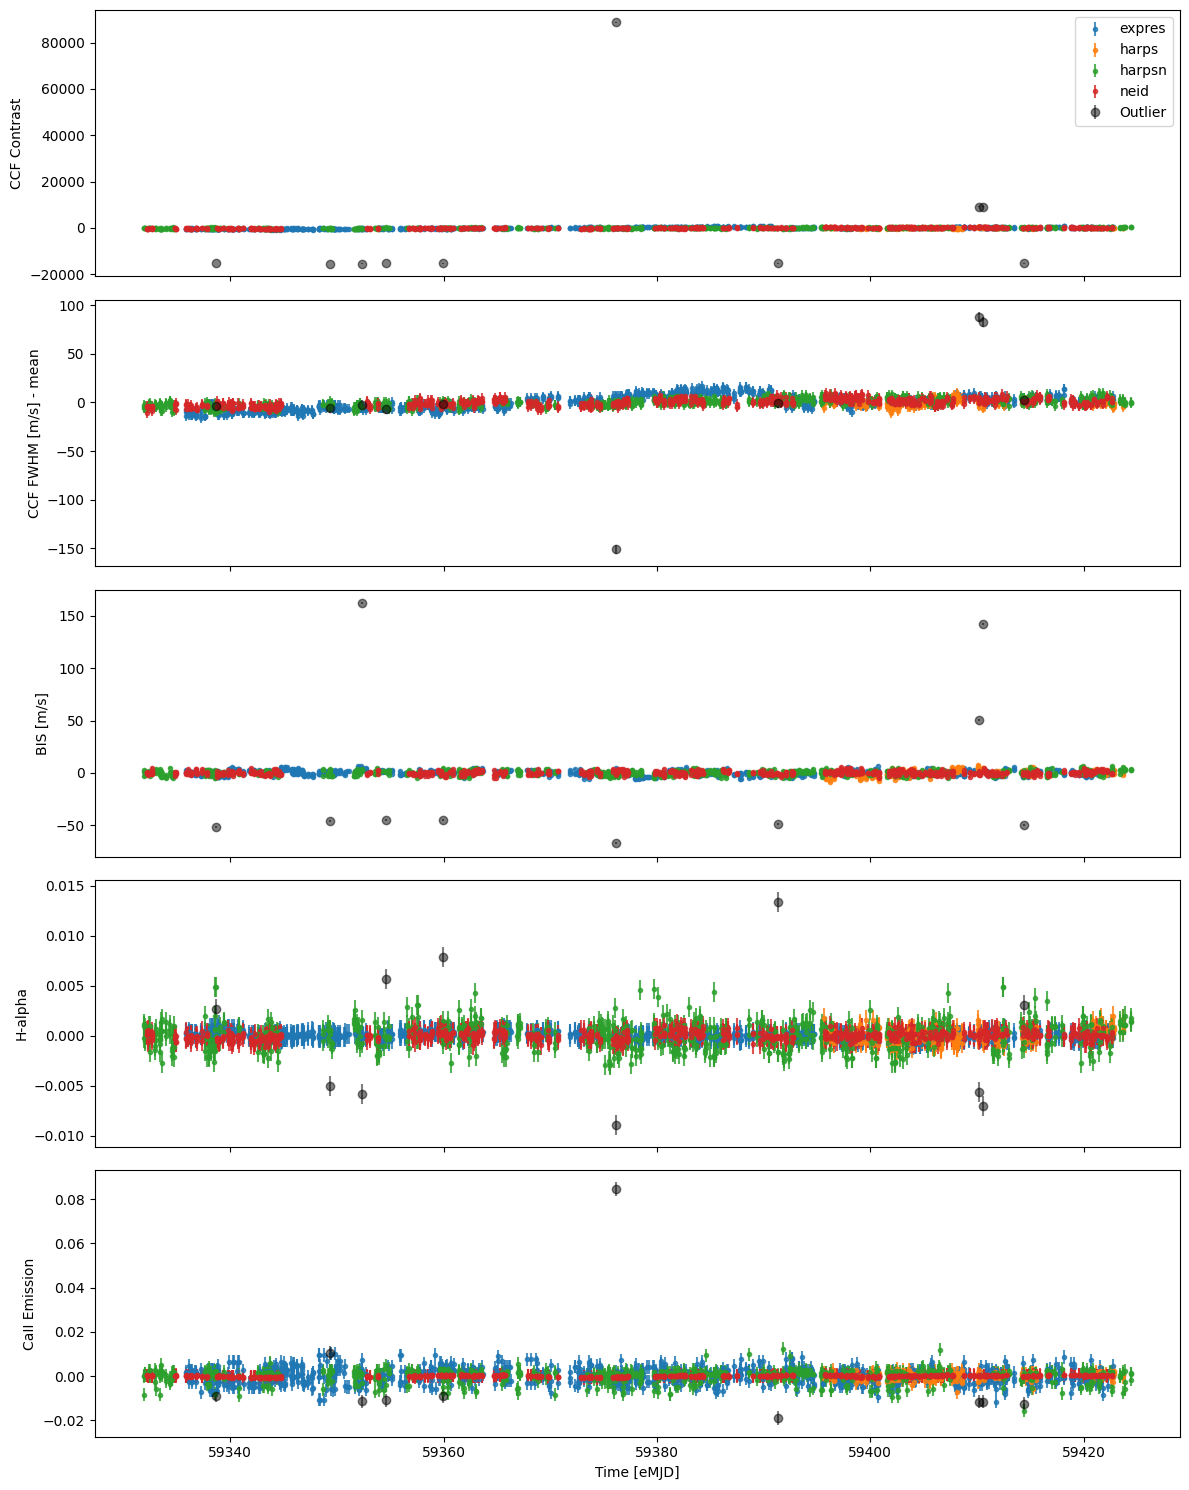

In [15]:
fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

plot_info = [
    ("CCF Contrast", 130, "CCF Contrast"),
    ("CCF FWHM [m/s]", 5.0, "CCF FWHM [m/s] - mean"),
    ("BIS [m/s]", 0.95, "BIS [m/s]"),
    ("H-alpha Emission", 0.001, "H-alpha"),
    ("CaII Emission", 0.003, "CaII Emission"),
]

inliers_all = df_all[~df_all.is_outlier]
outliers_all = df_all[df_all.is_outlier]

for ax, (col, yerr, ylabel) in zip(axes, plot_info):
    # Inliers
    for inst, g in inliers_all.groupby("Instrument"):
        ax.errorbar(
            g["Time [eMJD]"],
            g[col] - g[col].mean(),
            yerr=yerr,
            fmt='.',
            label=inst,
            alpha=0.8
        )
    # Outliers
    if not outliers_all.empty and col in outliers_all.columns:
        ax.errorbar(
            outliers_all["Time [eMJD]"],
            outliers_all[col] - outliers_all[col].mean(),
            yerr=yerr,
            fmt='o',
            color='black',
            alpha=0.5,
            label='Outlier'
        )
    ax.set_ylabel(ylabel)

axes[-1].set_xlabel("Time [eMJD]")
handles, labels = axes[0].get_legend_handles_labels()
uniq = dict(zip(labels, handles))
axes[0].legend(uniq.values(), uniq.keys(), loc="best")

plt.tight_layout()
plt.show()
